#### Random forest
Para el el modelo de prediccion de la demanda de taxi en la ciudad de nueva york, 

In [1]:
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.linear_model import LinearRegression
from sklearn import tree
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
df_taxi = pd.read_csv('Taxi_2023_Cleaned.csv')

In [3]:
# Se visualizan las primeras filas del Dataframe
df_taxi.head(3)

,PULocationID,Borough,Zone,Service_Zone,Passenger_Count,Trip_Distance,DOLocationID,RatecodeID,Store_and_fwd_flag,Total_Amount,Date_pickup,Time_pickup,Date_dropoff,Time_dropoff
0,161,Manhattan,Midtown Center,Yellow Zone,1.0,2.81,158,1.0,N,24.36,2023-08-08,05:08:25,2023-08-08,05:23:40
1,161,Manhattan,Midtown Center,Yellow Zone,1.0,1.30,107,1.0,N,16.00,2023-08-08,08:47:43,2023-08-08,08:55:47
2,161,Manhattan,Midtown Center,Yellow Zone,1.0,0.44,230,1.0,N,12.12,2023-08-08,13:56:30,2023-08-08,14:00:03


In [5]:
#Se extrae mes, dias, horas y dia de la semana de las columnas Date_pickup y Time_pickup
df_taxi['month'] = pd.DatetimeIndex(df_taxi['Date_pickup']).month

In [ ]:
df_taxi['dayofweek'] = pd.DatetimeIndex(df_taxi['Date_pickup']).dayofweek

In [6]:
df_taxi['hour'] = pd.DatetimeIndex(df_taxi['Time_pickup']).hour

In [7]:
# Se convierten las columnas de fecha y hora a formato datetime
df_taxi['Date_pickup'] = pd.to_datetime(df_taxi['Date_pickup'])

In [8]:
df_taxi['Time_pickup'] = pd.to_datetime(df_taxi['Time_pickup'])

In [9]:
# Se crea una nueva columna para la fecha y hora completa
df_taxi['Datetime_pickup'] = df_taxi['Date_pickup'] + pd.to_timedelta(df_taxi['Time_pickup'].dt.hour, unit='H')

In [10]:
# Agrupar los datos por hora y contar la cantidad de viajes
demanda_por_hora = df_taxi.groupby(df_taxi['Datetime_pickup'].dt.hour)['Passenger_Count'].count()

In [11]:
df_taxi.rename(columns={'hour': 'Hour', 'dayofweek': 'Dayofweek' }, inplace=True)

In [4]:
# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
demanda_por_hora.plot(kind='bar', color='orange')

# Personalizar el gráfico
plt.title('Demanda de taxis por hora del día')
plt.xlabel('Hora del día')
plt.ylabel('Cantidad de viajes')
plt.xticks(rotation=0)

# Mostrar el gráfico
plt.show()

NameError: name 'demanda_por_hora' is not defined

<Figure size 1000x600 with 0 Axes>

En este grafico podemos observar que la frecuencia de servicios de taxi es mayor en las horas pico (17-19), y menor en las horas (3-5) de la mañana. 

### Agrupamos los datos por Destino, Hora y día, y se calcula la demanda

In [13]:
#Agrupando por localizacion y tiempo
df_taxi = df_taxi.groupby(['Hour','PULocationID','Dayofweek']).size().reset_index(name='Demanda')

In [14]:
# Se calcula el porcentaje de la demanda
df_taxi['Demanda'] = df_taxi['Demanda'].apply(lambda x :  (x / df_taxi['Demanda'].max()))
df_taxi['Demanda'] = round(df_taxi['Demanda']*100,2)

In [15]:
# Se guardan los datos en un csv
df_taxi.to_csv('Taxi_ML.csv', index=False)

In [16]:
# Validamos cuando se presentan la mayor demanda.
taxi_top = df_taxi.sort_values(by='Demanda', ascending=False)
taxi_top.head()

,Hour,PULocationID,Dayofweek,Demanda
3886,18,161,1,100.00
3887,18,161,2,92.05
4097,19,161,2,89.87
4096,19,161,1,88.31
3676,17,161,1,87.97


La zona con mayor demanda corresponde a Midtown Center (ID: 161), en el distritro de Manhattan

In [17]:
# Obtenemos la información general del dataframe
df_taxi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5040 entries, 0 to 5039
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Hour          5040 non-null   int32  
 1   PULocationID  5040 non-null   int64  
 2   Dayofweek     5040 non-null   int32  
 3   Demanda       5040 non-null   float64
dtypes: float64(1), int32(2), int64(1)
memory usage: 118.3 KB


In [18]:
# Se definen las características y la variable objetivo
caracteristicas = ['PULocationID', 'Dayofweek', 'Hour']
variable_objetivo = 'Demanda'

# Se seleccionan las características (X) y la variable objetivo (y)
X = df_taxi[caracteristicas]
y = df_taxi[variable_objetivo]

In [19]:
# Se dividen los datos en características (X) y etiquetas (y) en conjuntos de entrenamiento (X_entrenamiento, y_entrenamiento) y prueba (X_prueba, y_prueba)
entrenamiento, prueba, obj_entrenamiento, obj_prueba = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
#Se crea una instancia del modelo RandomForestRegressor
rf_model = RandomForestRegressor()
rf_model.fit(entrenamiento, obj_entrenamiento)

RandomForestRegressor()

In [21]:
#Se utilizan las características del conjunto de prueba (X_prueba) para hacer predicciones
predictions = rf_model.predict(prueba)

In [22]:
mse = mean_squared_error(obj_prueba, predictions)

In [23]:
# Calcular las métricas de evaluación
error_absoluto_medio = mean_absolute_error(obj_prueba, predictions)
error_cuadratico_medio = mean_squared_error(obj_prueba, predictions)
raiz_error_cuadratico_medio = np.sqrt(error_cuadratico_medio)
r_cuadrado = r2_score(obj_prueba, predictions)

# Imprimir las métricas de evaluación
print('Error Absoluto Medio (MAE):', error_absoluto_medio)
print('Error Cuadrático Medio (MSE):', error_cuadratico_medio)
print('Raíz del Error Cuadrático Medio (RMSE):', raiz_error_cuadratico_medio)
print('Coeficiente de Determinación (R^2):', r_cuadrado)

Error Absoluto Medio (MAE): 1.705213392857143
Error Cuadrático Medio (MSE): 7.940024005009922
Raíz del Error Cuadrático Medio (RMSE): 2.817804820247478
Coeficiente de Determinación (R^2): 0.9704277719552142


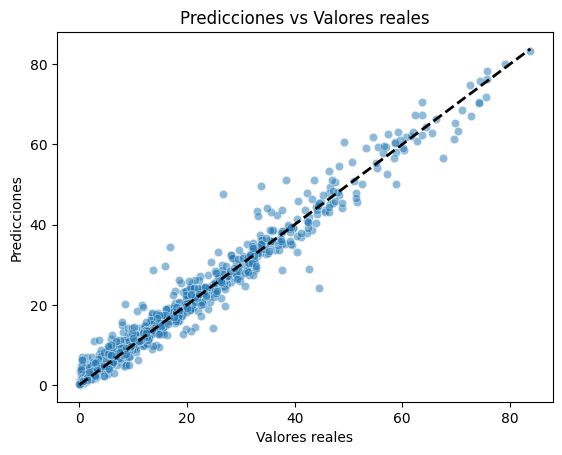

In [24]:
# Crear un DataFrame con los valores reales y las predicciones
df_visualizacion = pd.DataFrame({'Valores reales': obj_prueba, 'Predicciones': predictions})

# Graficar las predicciones versus los valores reales
sns.scatterplot(x='Valores reales', y='Predicciones', data=df_visualizacion, alpha=0.5)
plt.plot([obj_prueba.min(), obj_prueba.max()], [obj_prueba.min(), obj_prueba.max()], 'k--', lw=2)
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')
plt.title('Predicciones vs Valores reales')
plt.show()

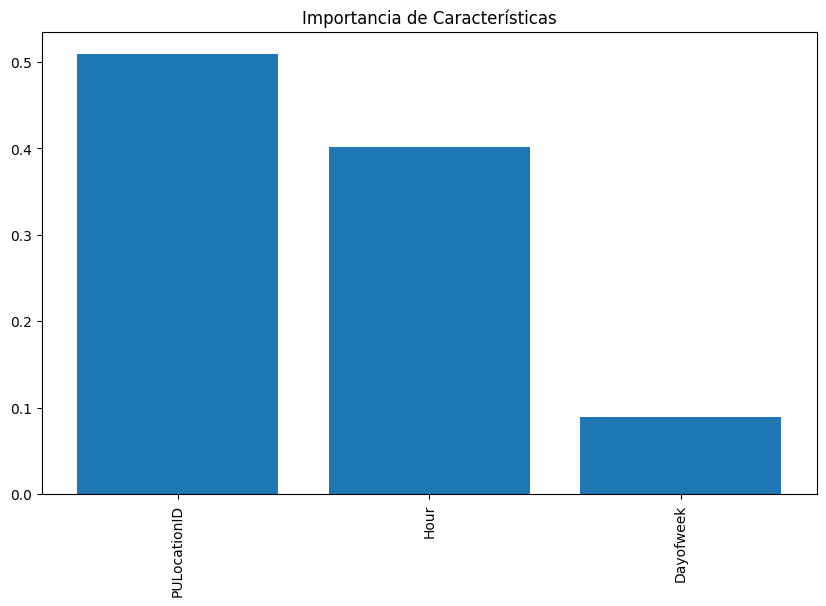

In [25]:
importances = rf_model.feature_importances_
feature_names = entrenamiento.columns  
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), feature_names[indices], rotation=90)
plt.title("Importancia de Características")
plt.show()

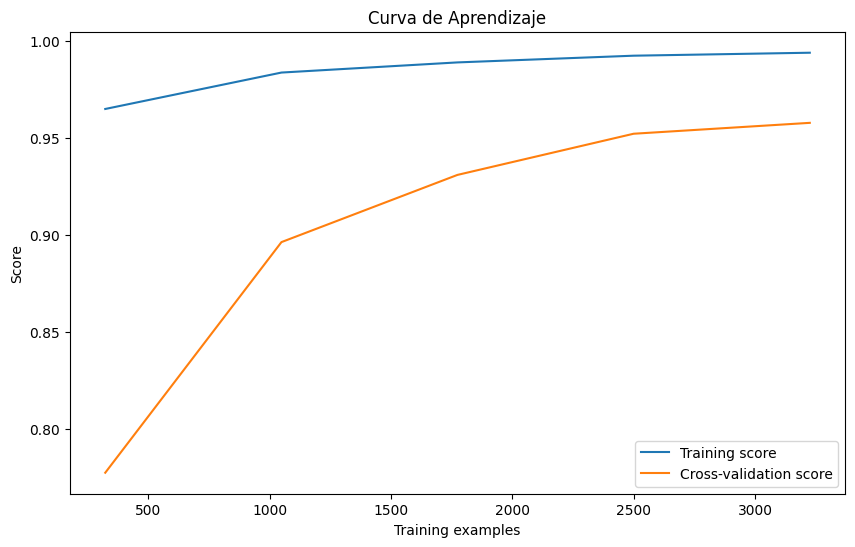

In [26]:
train_sizes, train_scores, test_scores = learning_curve(rf_model, entrenamiento, obj_entrenamiento, cv=5)
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training score')
plt.plot(train_sizes, test_scores_mean, label='Cross-validation score')
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.legend(loc="best")
plt.title("Curva de Aprendizaje")
plt.show()

In [27]:
# Realizar predicciones en el conjunto de prueba
predicciones_random_forest = rf_model.predict(entrenamiento)

# Imprimir las predicciones
print('Predicciones (RandomForest):', predicciones_random_forest)

Predicciones (RandomForest): [ 1.0518  0.5625  8.6879 ...  1.0121 17.5953 10.572 ]
